This file was created in the course of my Udacity Data Scientist Nanodegree program.

A data analysis on data from Airbnb is performed to gain insights into Vienna's Airbnb listings. Anyway, this notebook can be applied to data from other Airbnb locations as well, assuming that the data structure is similar.

In [33]:
# import main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pio.renderers.default = "png"
import dataframe_image as dfi
%matplotlib notebook

# optical benefits
pd.set_option('float_format', '{:.2f}'.format)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [34]:
# import data
#df_listings = pd.read_csv('./data/listings.csv')
df_listings_details = pd.read_csv('./data/listings.csv.gz')
#df_reviews = pd.read_csv('./data/reviews.csv')
#df_reviews_details = pd.read_csv('./data/reviews.csv.gz')
#df_neighbourhoods = pd.read_csv('./data/neighbourhoods.csv')
#df_calendar = pd.read_csv('./data/calendar.csv.gz')

### Pre-processing of the data

In [35]:
# convert prices to float
df_listings_details['price'] = df_listings_details['price'].str[1:].replace(',', '', regex=True).astype(float)

### Basic listings statistics

In [36]:
# check for missing values
print('Room type missing values: ', df_listings_details['room_type'].isna().any())
print('Price missing values: ', df_listings_details['price'].isna().any())

Room type missing values:  False
Price missing values:  False


In [37]:
# create dataframe with basic listings statistics
basic_listings_stats_series = df_listings_details['room_type'].value_counts()
basic_listings_stats = pd.DataFrame({'Room Type': basic_listings_stats_series.index, 'Number of Listings': basic_listings_stats_series.values})

In [38]:
# add percent columns to dataframe and show dataframe
def calculate_perc(row):
    return row['Number of Listings']/sum(basic_listings_stats['Number of Listings'])*100
basic_listings_stats['Percent of Total'] = basic_listings_stats.apply(calculate_perc, axis=1)
basic_listings_stats

,Room Type,Number of Listings,Percent of Total
0,Entire home/apt,9090,77.05
1,Private room,2575,21.83
2,Shared room,76,0.64
3,Hotel room,56,0.47


In [39]:
# total number of listings
print('Total number of listings:', sum(basic_listings_stats['Number of Listings']))

Total number of listings: 11797


In [40]:
# export as dataframe as png
dfi.export(basic_listings_stats, 'Basic_listings_stats.png')

In [41]:
# print price statistics for the room types
df_listings_details.groupby('room_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,9090.00,105.16,171.44,10.00,60.00,80.00,114.00,9200.00
Hotel room,56.00,137.73,78.84,0.00,85.00,137.50,178.25,430.00
Private room,2575.00,60.10,259.65,10.00,25.00,35.00,52.00,9270.00
Shared room,76.00,43.24,37.92,9.00,23.50,30.00,45.00,203.00


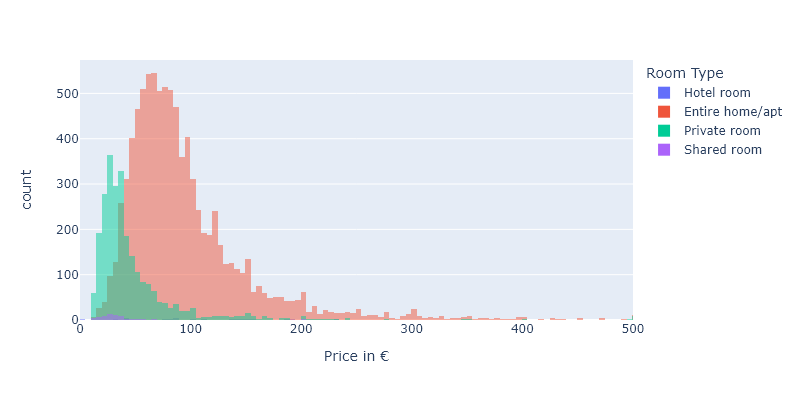

In [42]:
# plot price distribution
fig = px.histogram(df_listings_details, x="price", color="room_type", barmode="overlay", labels=dict(price="Price in €", room_type="Room Type"), width=800, height=400, nbins=2000)
fig.update_xaxes(range=[0, 500])
fig.show()

In [43]:
# show mean prices for each room type
df_listings_details.groupby('room_type')['price'].mean()

room_type
Entire home/apt   105.16
Hotel room        137.73
Private room       60.10
Shared room        43.24
Name: price, dtype: float64

### Hosts statistics

In [44]:
# check for missing values
print('Host ID missing values: ', df_listings_details['host_id'].isna().any())
print('Host listings count missing values: ', df_listings_details['calculated_host_listings_count'].isna().any())
print('Room Type missing values: ', df_listings_details['room_type'].isna().any())
print('Prince missing values: ', df_listings_details['price'].isna().any())

Host ID missing values:  False
Host listings count missing values:  False
Room Type missing values:  False
Prince missing values:  False


In [45]:
# creat dataframe for hosts statistics
df_listings_counts = df_listings_details[['host_id', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms']].drop_duplicates()

In [46]:
# print number of hosts and listings with consistency checks
print('Number of Hosts: ', df_listings_details['host_id'].nunique())
print('Number of Hosts: ', df_listings_counts['host_id'].shape[0]) # check if consistent
print('Number of Listings: ', df_listings_details['id'].nunique())
print('Number of Listings: ', sum(df_listings_counts['calculated_host_listings_count'])) # check if consistent

Number of Hosts:  6514
Number of Hosts:  6514
Number of Listings:  11797
Number of Listings:  11797


In [47]:
# plot number of hosts
print('Number of hosts: ', df_listings_counts['host_id'].nunique())

Number of hosts:  6514


In [48]:
# create sorted dataframe
df_listings_counts_sorted = df_listings_counts.sort_values('calculated_host_listings_count', ascending=False)

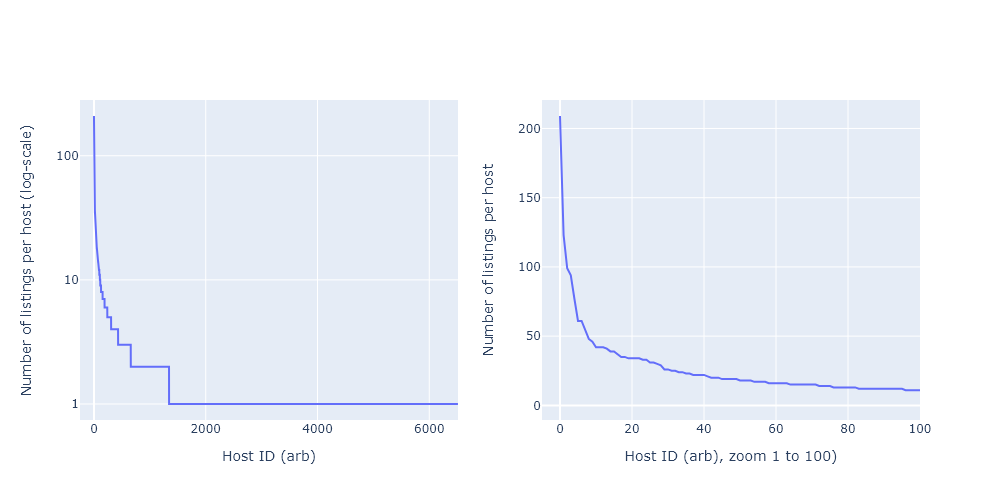

In [60]:
# plot number of listings vs host id

fig = make_subplots(rows=1, cols=2, shared_yaxes=False)

fig.add_trace(go.Scatter(y=df_listings_counts_sorted['calculated_host_listings_count'], marker_color='#636EFA'), 1, 1)
fig.add_trace(go.Scatter(y=df_listings_counts_sorted['calculated_host_listings_count'], marker_color='#636EFA'), 1, 2)

fig.update_xaxes(title_text="Host ID (arb)", row=1, col=1)
fig.update_xaxes(title_text="Host ID (arb), zoom 1 to 100)", row=1, col=2)
fig.update_xaxes(range=[-250, df_listings_counts['host_id'].shape[0]], row=1, col=1)
fig.update_xaxes(range=[-5, 100], row=1, col=2)

fig.update_yaxes(title_text="Number of listings per host (log-scale)", type="log", tickvals=[0, 1, 10, 100],  row=1, col=1)
fig.update_yaxes(title_text="Number of listings per host", row=1, col=2)

fig.update_layout(showlegend=False)
fig.update_layout(autosize=False, width=1000, height=500)
fig.show()

In [50]:
# show number of hosts with 1 to 5 listings
df_listings_counts_sorted['calculated_host_listings_count'].value_counts()[:5]

1    5170
2     685
3     227
4     125
5      68
Name: calculated_host_listings_count, dtype: int64

In [51]:
# show number of listing of hosts with most listings
df_listings_counts_sorted['calculated_host_listings_count'][:5]

8299    209
5154    123
5619     99
4113     94
398      77
Name: calculated_host_listings_count, dtype: int64

In [52]:
# prepare data for pie plot
df_pie_0_4 = df_listings_counts['calculated_host_listings_count'].value_counts()[:4]
df_pie_4_ = df_listings_counts['calculated_host_listings_count'].value_counts()[4:].sum()

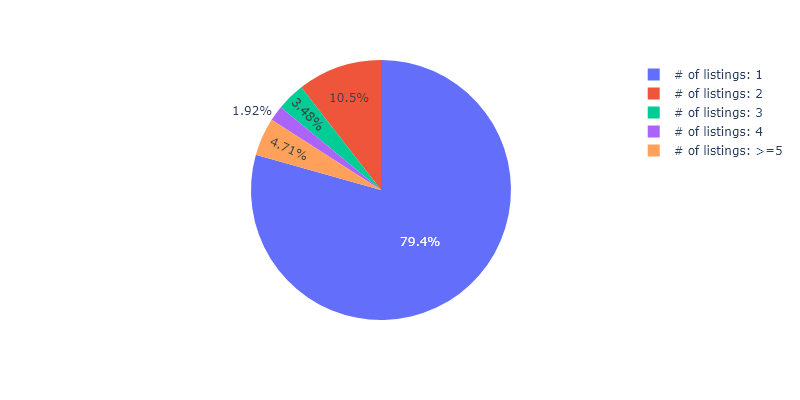

In [53]:
# pie plot for number of listings per host
names = ['# of listings: ' + str(df_pie_0_4.index[i]) for i in range(4)]
names.append('# of listings: >=5')
fig = px.pie(values=np.append(df_pie_0_4.values, df_pie_4_), names=names, width=800, height=400)
fig.update_traces(sort=False, selector=dict(type='pie'))
fig.show()

### Private vs. professional Hosts

In [54]:
# take a look at available columns
df_listings_details.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [55]:
# check for missing values
print('Host ID missing values: ', df_listings_details['host_id'].isna().any())
print('Host listings count missing values: ', df_listings_details['calculated_host_listings_count'].isna().any())
print('Room Type missing values: ', df_listings_details['room_type'].isna().any())
print('Prince missing values: ', df_listings_details['price'].isna().any())
print('Availability missing values: ', df_listings_details['availability_365'].isna().any())
print('Number of reviews missing values: ', df_listings_details['number_of_reviews_ltm'].isna().any())
print('Minimum nights missing values: ', df_listings_details['minimum_nights'].isna().any())
print('Maximum nights missing values: ', df_listings_details['maximum_nights'].isna().any())

Host ID missing values:  False
Host listings count missing values:  False
Room Type missing values:  False
Prince missing values:  False
Availability missing values:  False
Number of reviews missing values:  False
Minimum nights missing values:  False
Maximum nights missing values:  False


In [56]:
# filter listings from private and professional hosts and entire home / department listings
professional_hosts = df_listings_details[(df_listings_details['calculated_host_listings_count'] >= 5) & (df_listings_details['room_type'] == 'Entire home/apt')]
private_hosts = df_listings_details[(df_listings_details['calculated_host_listings_count'] == 1) & (df_listings_details['room_type'] == 'Entire home/apt')]
#professional_hosts = df_listings_details[(df_listings_details['calculated_host_listings_count'] >= 5)]
#private_hosts = df_listings_details[(df_listings_details['calculated_host_listings_count'] == 1)]

In [57]:
# create dataframe to compare professional and private hosts
professional_vs_private = pd.DataFrame(columns=['metric', 'professional_hosts', 'private_hosts'])
data = pd.DataFrame({'metric': ['number_of_hosts', 'total_listings', 'mean_price', 'mean_availability', 'review_scores_rating'],
                        'professional_hosts': [professional_hosts['host_id'].nunique(), professional_hosts.shape[0], professional_hosts['price'].mean(), professional_hosts['availability_365'].mean(),  professional_hosts['review_scores_rating'].mean()],
                        'private_hosts': [private_hosts['host_id'].nunique(), private_hosts.shape[0], private_hosts['price'].mean(), private_hosts['availability_365'].mean(), private_hosts['review_scores_rating'].mean()]}) 

professional_vs_private = pd.concat([professional_vs_private, data])

In [58]:
# prepare a dataframe for the plots
professional_vs_private_melted = pd.melt(professional_vs_private, id_vars=['metric'], value_vars=['professional_hosts', 'private_hosts'], var_name='host_type')

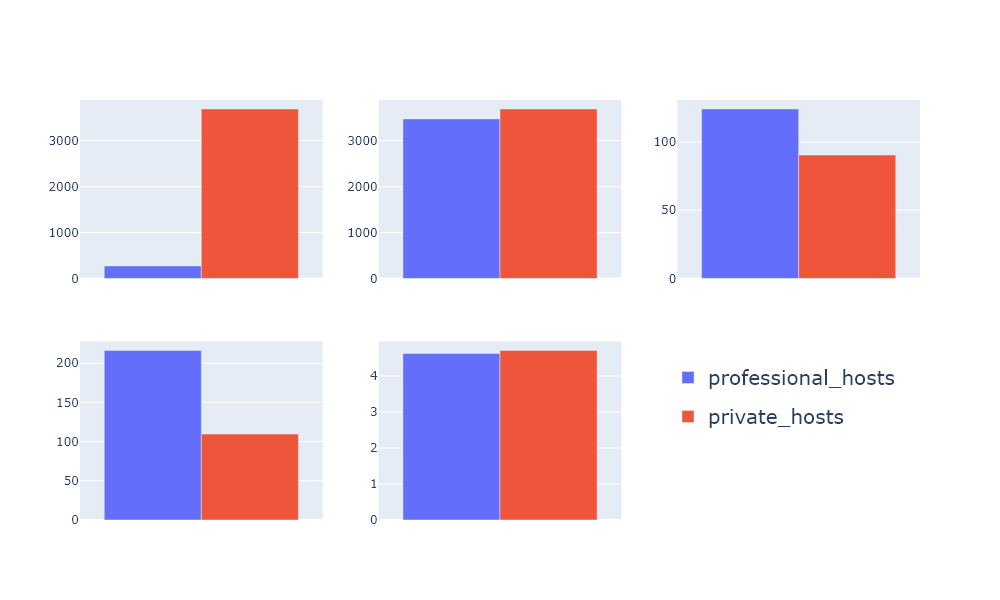

In [59]:
# plot professional vs private host comparison

columns = ['number_of_hosts', 'total_listings', 'mean_price', 'mean_availability', 'review_scores_rating']
host_types = ['professional_hosts', 'private_hosts']

fig = make_subplots(rows=2, cols=3, shared_yaxes=False)

fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[0])
                        & (professional_vs_private_melted['host_type'] == host_types[0])]['value'], marker_color='#636EFA',
                        name=host_types[0], legendgroup='group1', showlegend=True), 1, 1)
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[0])
                        & (professional_vs_private_melted['host_type'] == host_types[1])]['value'], marker_color='#EF553B',
                        name=host_types[1], legendgroup='group2', showlegend=True), 1, 1)

fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[1])
                        & (professional_vs_private_melted['host_type'] == host_types[0])]['value'], marker_color='#636EFA',
                        name=host_types[0], legendgroup='group1', showlegend=False), 1, 2)
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[1])
                        & (professional_vs_private_melted['host_type'] == host_types[1])]['value'], marker_color='#EF553B',
                        name=host_types[1], legendgroup='group2', showlegend=False), 1, 2)

fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[2])
                        & (professional_vs_private_melted['host_type'] == host_types[0])]['value'], marker_color='#636EFA',
                        name=host_types[0], legendgroup='group1', showlegend=False),1, 3)
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[2])
                        & (professional_vs_private_melted['host_type'] == host_types[1])]['value'], marker_color='#EF553B',
                        name=host_types[1], legendgroup='group2', showlegend=False), 1, 3)

fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[3])
                        & (professional_vs_private_melted['host_type'] == host_types[0])]['value'], marker_color='#636EFA',
                        name=host_types[0], legendgroup='group1', showlegend=False), 2, 1)
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[3])
                        & (professional_vs_private_melted['host_type'] == host_types[1])]['value'], marker_color='#EF553B',
                        name=host_types[1], legendgroup='group2', showlegend=False), 2, 1)
                        
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[4])
                        & (professional_vs_private_melted['host_type'] == host_types[0])]['value'], marker_color='#636EFA',
                        name=host_types[0], legendgroup='group1', showlegend=False), 2, 2)
fig.add_trace(go.Bar(y=professional_vs_private_melted[(professional_vs_private_melted['metric'] == columns[4])
                        & (professional_vs_private_melted['host_type'] == host_types[1])]['value'], marker_color='#EF553B',
                        name=host_types[1], legendgroup='group2', showlegend=False), 2, 2)
                        
fig.update_xaxes(visible=False)
fig.update_layout(showlegend=True)
fig.update_layout(autosize=False, width=1000, height=600)
fig.update_layout(legend=dict(y=0.20, x=0.70, font=dict(size=20)))
fig.show()